In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..'))

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import yaml

In [5]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/MI/MI_probation_model_inputs.yaml')
# test_sim.simulate_baseline('prison_shell', 'probation')

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 288 results
transitions_data returned 6 results
total_population_data returned 96 results


initialization time:  2.102167844772339
simulation_time:  7.930006980895996
initialization time:  2.0204648971557617
simulation_time:  7.9182288646698


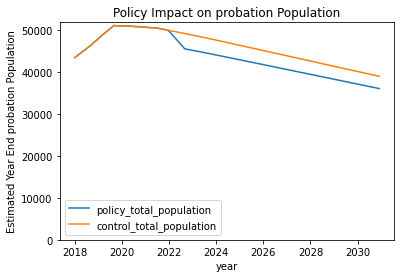

In [6]:
def apply_reduced_probation_cap(retroactive=True):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'],
                                              'affected_fraction': [0.25], 
                                              'reduction_size': [0.4]}), 
                   reduction_type='*', retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap(retroactive=False),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

In [16]:
simulation_tag = 'MI_1050_eligibility_25_pct'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

  compartment                 scenario    population simulation_date  \
0      prison  policy_total_population  10845.833333      2018-01-01   
1      prison  policy_total_population  11099.000000      2018-02-01   
2      prison  policy_total_population  11352.166667      2018-03-01   
3      prison  policy_total_population  11605.333333      2018-04-01   
4      prison  policy_total_population  11858.500000      2018-05-01   

               simulation_tag               date_created  
0  MI_1050_eligibility_25_pct 2020-12-22 16:50:02.266553  
1  MI_1050_eligibility_25_pct 2020-12-22 16:50:02.266553  
2  MI_1050_eligibility_25_pct 2020-12-22 16:50:02.266553  
3  MI_1050_eligibility_25_pct 2020-12-22 16:50:02.266553  
4  MI_1050_eligibility_25_pct 2020-12-22 16:50:02.266553  


In [5]:
from recidiviz.calculator.modeling.population_projection.predicted_admissions import PredictedAdmissions
historical_data = pd.DataFrame([[57899, 59472, 53375, 49458, 47526, 49643, 45135, 44931, 43482, 43048]],
                               columns=range(2009, 2019), index=['probation'])
predicted_probation = PredictedAdmissions(historical_data, constant_admissions=False)
predictions = {}
for year in range(2019, 2026):
    predictions[year] = predicted_probation.get_time_step_estimate(year)['probation']
#predictions

Text(0, 0.5, 'Avg Yearly Probation Population')

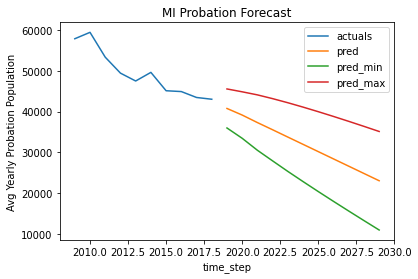

In [6]:
arima_output_df = predicted_probation.gen_arima_output_df().droplevel('outflow_to')
arima_output_df.plot(y=['actuals', 'pred', 'pred_min', 'pred_max'])
plt.title('MI Probation Forecast')
plt.ylabel('Avg Yearly Probation Population')

In [18]:
arima_output_df

,pred,pred_min,pred_max,stderr,actuals
time_step,,,,,
2009,NaN,NaN,NaN,NaN,57899.0
2010,NaN,NaN,NaN,NaN,59472.0
2011,NaN,NaN,NaN,NaN,53375.0
2012,NaN,NaN,NaN,NaN,49458.0
2013,NaN,NaN,NaN,NaN,47526.0
2014,NaN,NaN,NaN,NaN,49643.0
2015,NaN,NaN,NaN,NaN,45135.0
2016,NaN,NaN,NaN,NaN,44931.0
2017,NaN,NaN,NaN,NaN,43482.0


In [19]:
for val in arima_output_df['pred_max'].values:
    print(f"{val}")

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
45574.996362564314
44872.13827551202
44118.69555394352
43194.52006550077
42189.15659843605
41115.88521740205
39990.9825626169
38824.156076210435
37622.43285769216
36391.16327973759
35134.39166918204


[<AxesSubplot:title={'center':'compartment: prison_shell\noutflow_to: probation'}>]

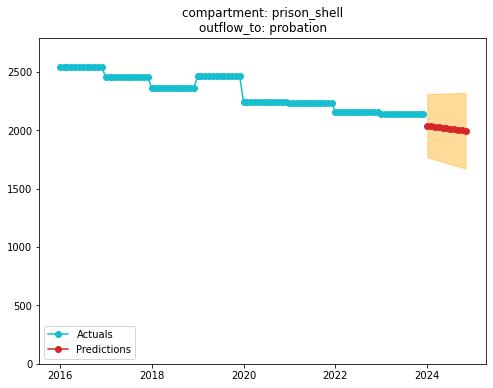

In [20]:
test_sim.gen_arima_output_plots()

<AxesSubplot:xlabel='time_step'>

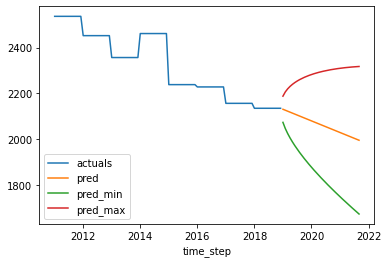

In [6]:
arima_output_df = test_sim.pop_simulations['baseline'].sub_simulations['felony']\
    .simulation_compartments['prison_shell'].admissions_predictors['before'].gen_arima_output_df().droplevel('outflow_to')
arima_output_df['time_step'] = arima_output_df.index
arima_output_df.index = arima_output_df.index.map(test_sim._convert_to_absolute_year)
arima_output_df.plot(y=['actuals', 'pred', 'pred_min', 'pred_max'])

In [6]:
arima_output_df['time_step'].values

array([-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
       -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
       -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
       -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
        -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68])

In [53]:
historical_data = test_sim.pop_simulations['baseline'].sub_simulations['felony']\
    .simulation_compartments['prison_shell'].admissions_predictors['before'].historical_data
column_rename = {old_col: test_sim._convert_to_absolute_year(old_col) for old_col in historical_data.columns}
historical_data = historical_data.rename(column_rename, axis=1)
historical_data

time_step,2011.000000,2011.083333,2011.166667,2011.250000,2011.333333,2011.416667,2011.500000,2011.583333,2011.666667,2011.750000,...,2018.166667,2018.250000,2018.333333,2018.416667,2018.500000,2018.583333,2018.666667,2018.750000,2018.833333,2018.916667
outflow_to,,,,,,,,,,,,,,,,,,,,,
probation,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,2537.166667,...,2134.75,2134.75,2134.75,2134.75,2134.75,2134.75,2134.75,2134.75,2134.75,2134.75


In [7]:
population_output = test_sim.output_data['policy_simulation']
population_output[(population_output['compartment'] == 'probation') & 
                  ((population_output['year'] % 1 > 0.8) | (population_output['year'] % 1 < 0.1))]

,compartment,year,policy_total_population,control_total_population
240,probation,2018.000000,43408.855754,43408.855754
241,probation,2018.083333,43766.628174,43766.628174
250,probation,2018.833333,47112.677910,47112.677910
251,probation,2018.916667,47537.793453,47537.793453
252,probation,2019.000000,47958.582451,47958.582451
253,probation,2019.083333,48360.212703,48360.212703
262,probation,2019.833333,50993.615444,50993.615444
263,probation,2019.916667,50990.043743,50990.043743
264,probation,2020.000000,50982.234322,50982.234322
265,probation,2020.083333,50970.187181,50970.187181


In [12]:
population_output = test_sim.output_data['policy_simulation']
population_output[(population_output['compartment'] == 'probation') & 
                  ((population_output['year'] % 1 > 0.8) | (population_output['year'] % 1 < 0.1))]

,compartment,year,policy_total_population,control_total_population
240,probation,2016.000000,45229.780377,45229.780377
241,probation,2016.083333,45527.144087,45527.144087
250,probation,2016.833333,48587.056390,48587.056390
251,probation,2016.916667,49089.267417,49089.267417
252,probation,2017.000000,49519.645112,49519.645112
253,probation,2017.083333,49939.522806,49939.522806
262,probation,2017.833333,52712.583333,52712.583333
263,probation,2017.916667,52630.250000,52630.250000
264,probation,2018.000000,52526.333333,52526.333333
265,probation,2018.083333,52419.333333,52419.333333


{'prison': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11929063880211138], 'prison_technicals': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14652680527128442], 'release': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7341825559266042]}
{'prison': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11929063880211138], 'prison_technicals': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14652680527128442], 'release': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029367302237064193, 0.04405095335559623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6607643003339437]}


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


initialization time:  2.387669086456299
simulation_time:  5.8823418617248535
initialization time:  2.153053045272827
simulation_time:  6.408753871917725


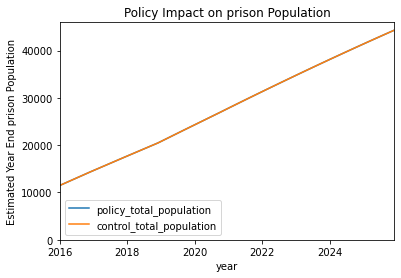

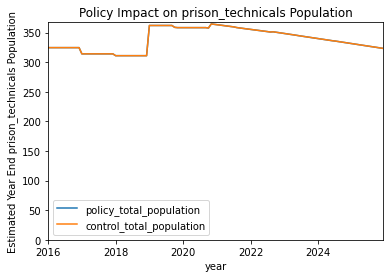

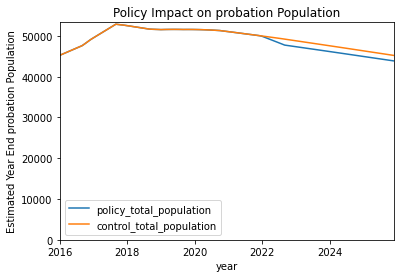

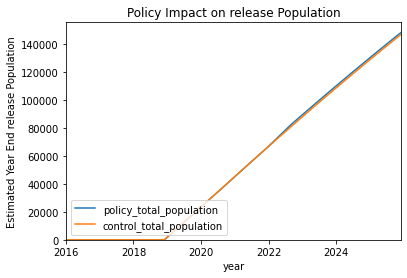

In [9]:
def apply_reduced_probation_cap(retroactive=True):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'release': 0.4}, 
                   reduction_type='*', percent_eligible=0.1, retroactive=retroactive)
#     return partial(CompartmentTransitions.apply_supervision_cap_reduction_MI, 
#                    supervision_period_reduction=0.4,
#                    percent_eligible=0.25, retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap(retroactive=False),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

In [10]:
simulation_tag = 'MI_1050_eligibility_10_pct'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

{'prison': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11929063880211138], 'prison_technicals': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14652680527128442], 'release': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7341825559266042]}
{'prison': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11929063880211138], 'prison_technicals': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14652680527128442], 'release': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11746920894825677, 0.17620381342238492, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4405095335559625]}


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


initialization time:  2.080887794494629
simulation_time:  6.830175876617432
initialization time:  2.1517090797424316
simulation_time:  6.1490159034729


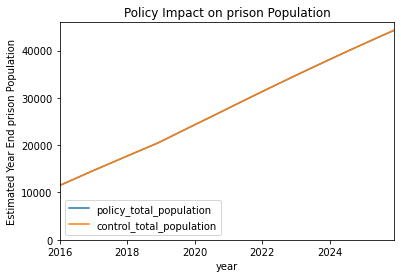

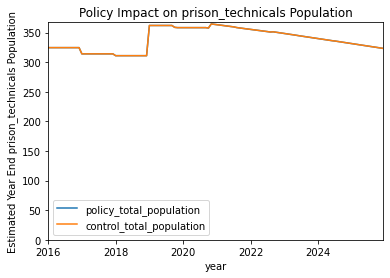

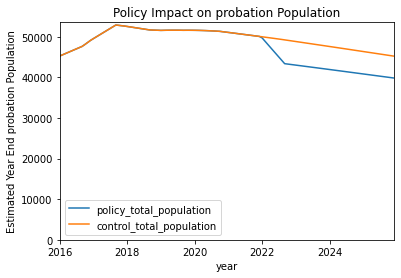

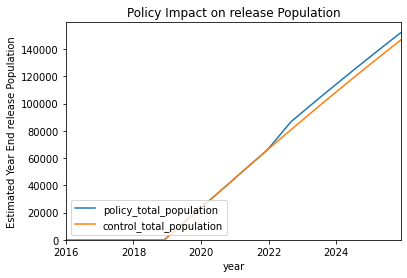

In [11]:
def apply_reduced_probation_cap(retroactive=True):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'release': 0.4}, 
                   reduction_type='*', percent_eligible=0.4, retroactive=retroactive)
#     return partial(CompartmentTransitions.apply_supervision_cap_reduction_MI, 
#                    supervision_period_reduction=0.4,
#                    percent_eligible=0.25, retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap(retroactive=False),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

In [12]:
simulation_tag = 'MI_1050_eligibility_40_pct'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [12]:
a, b = test_results
a.to_csv('MI_1050_spending_diff.csv')
b.to_csv('MI_1050_life_months_of_saved.csv')
test_sim.output_data['policy_simulation'].to_csv('MI_1050_total_populations')

In [15]:
test_sim.pop_simulations['policy'].sub_simulations['felony'].simulation_compartments['probation'].transition_tables.transition_dfs

{'before':       prison  prison_technicals   release  death  remaining
 1   0.000000           0.000000  0.000000  0.000        1.0
 2   0.000000           0.000000  0.000000  0.000        1.0
 3   0.000000           0.000000  0.000000  0.000        1.0
 4   0.000000           0.000000  0.000000  0.000        1.0
 5   0.000000           0.000000  0.000000  0.000        1.0
 6   0.000000           0.000000  0.000000  0.000        1.0
 7   0.000000           0.000000  0.000000  0.000        1.0
 8   0.000000           0.000000  0.000000  0.000        1.0
 9   0.000000           0.000000  0.000000  0.000        1.0
 10  0.000000           0.000000  0.000000  0.000        1.0
 11  0.000000           0.000000  0.000000  0.000        1.0
 12  0.000000           0.000000  0.000000  0.000        1.0
 13  0.000000           0.000000  0.000000  0.000        1.0
 14  0.000000           0.000000  0.000000  0.000        1.0
 15  0.000000           0.000000  0.000000  0.000        1.0
 16  0.000000 

In [28]:
a['probation'] = a.probation * (1 + ( (0.119291 * 9 / 21)))
b['probation'] = b.probation * (1 + ( (0.119291 * 9 / 21)))

In [32]:
a

,prison,release,prison_technicals,probation
year,,,,
2016.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.083333,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.166667,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.250000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.333333,0.000000e+00,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...
2025.583333,3.029724e+06,0.0,-8.980683e+06,-3.024036e+08
2025.666667,2.481215e+06,0.0,-9.249246e+06,-3.083971e+08
2025.750000,1.885919e+06,0.0,-9.517224e+06,-3.143774e+08
